
# Tanager / PRISMA / EnMAP SNR Comparison
Compare columnwise SNR (case D by default) across Tanager, PRISMA, and EnMAP using `snr_cases_*.csv` outputs. Smile/striping sections are omitted.

Units: EnMAP/PRISMA SNR exports use radiance in µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$; Tanager radiance is W m$^{-2}$ sr$^{-1}$ µm$^{-1}$. We convert Tanager mean radiance by 0.1 to the same basis before brightness normalisation so ratios are meaningful.


In [25]:

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Mapping, Sequence, Tuple

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")

os.environ.setdefault("PYTHONPATH", str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

plt.style.use("seaborn-v0_8-colorblind")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

print(f"Notebook root: {NOTEBOOK_ROOT}")
print(f"Repo root: {REPO_ROOT}")


Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks
Repo root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas


In [26]:

DEFAULT_SNR_CASES = ["D"]
SNR_AGGREGATION = "columnwise"
# Convert mean radiance to common basis µW cm^-2 sr^-1 nm^-1
UNIT_SCALE = {
    "enmap": 1.0,
    "prisma": 1.0,
    "tanager": 0.1,  # 1 W m^-2 sr^-1 µm^-1 = 0.1 µW cm^-2 sr^-1 nm^-1
}

SCENE_CONFIG: Dict[str, Dict[str, object]] = {
    "enmap": {
        "snr_output_dir": NOTEBOOK_ROOT
        / "outputs"
        / "enmap"
        / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z",
    },
    "prisma": {
        "snr_output_dir": NOTEBOOK_ROOT
        / "outputs"
        / "prisma"
        / "20200401085313",
    },
    "tanager": {
        "snr_output_dir": NOTEBOOK_ROOT
        / "outputs"
        / "tanager"
        / "basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5",
    },
}
SCENE_CONFIG


{'enmap': {'snr_output_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z')},
 'prisma': {'snr_output_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313')},
 'tanager': {'snr_output_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5')}}

In [27]:

from functools import lru_cache

EPS = 1e-9

@lru_cache(maxsize=8)
def load_snr_case(sensor_name: str, case: str, aggregation: Optional[str] = None) -> pd.DataFrame:
    sensor_cfg = SCENE_CONFIG[sensor_name]
    out_dir = Path(sensor_cfg["snr_output_dir"]).expanduser()
    case = case.upper()
    csv_path = out_dir / f"snr_cases_{case}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing SNR case output: {csv_path}")
    df = pd.read_csv(csv_path)
    if aggregation is not None:
        df = df[df["aggregation"] == aggregation]
        if df.empty:
            raise ValueError(f"No rows for aggregation '{aggregation}' in {csv_path}")
    df = df.sort_values("band_nm").reset_index(drop=True)
    df["sensor"] = sensor_name
    df["case"] = case
    scale = UNIT_SCALE.get(sensor_name, 1.0)
    df["mu"] = df["mu"] * scale
    return df

def align_and_scale_snr(ref_df: pd.DataFrame, other_df: pd.DataFrame) -> pd.DataFrame:
    cols_needed = ["band_nm", "mu", "snr_median", "snr_p90"]
    for col in cols_needed:
        if col not in ref_df or col not in other_df:
            raise KeyError(f"Column '{col}' missing from SNR inputs")

    ref_sorted = ref_df.sort_values("band_nm")
    oth_sorted = other_df.sort_values("band_nm")

    wl_min = max(ref_sorted["band_nm"].min(), oth_sorted["band_nm"].min())
    wl_max = min(ref_sorted["band_nm"].max(), oth_sorted["band_nm"].max())
    overlap_mask = (ref_sorted["band_nm"] >= wl_min) & (ref_sorted["band_nm"] <= wl_max)
    if not overlap_mask.any():
        raise ValueError("No overlapping wavelength range between datasets")

    wl_target = ref_sorted.loc[overlap_mask, "band_nm"].to_numpy()

    def _interp(df: pd.DataFrame, col: str) -> np.ndarray:
        return np.interp(wl_target, df["band_nm"], df[col])

    ref_mu = _interp(ref_sorted, "mu")
    ref_median = _interp(ref_sorted, "snr_median")
    ref_p90 = _interp(ref_sorted, "snr_p90")

    oth_mu = _interp(oth_sorted, "mu")
    oth_median = _interp(oth_sorted, "snr_median")
    oth_p90 = _interp(oth_sorted, "snr_p90")

    scale = np.sqrt(np.clip(ref_mu, a_min=0.0, a_max=None) / np.clip(oth_mu, a_min=EPS, a_max=None))

    comparison = pd.DataFrame({
        "band_nm": wl_target,
        "mu_ref": ref_mu,
        "mu_other_raw": oth_mu,
        "snr_median_ref": ref_median,
        "snr_median_other_raw": oth_median,
        "snr_p90_ref": ref_p90,
        "snr_p90_other_raw": oth_p90,
        "scale_factor": scale,
    })

    comparison["snr_median_other_scaled"] = comparison["snr_median_other_raw"] * comparison["scale_factor"]
    comparison["snr_p90_other_scaled"] = comparison["snr_p90_other_raw"] * comparison["scale_factor"]
    comparison["snr_median_ratio"] = comparison["snr_median_ref"] / np.clip(comparison["snr_median_other_scaled"], a_min=EPS, a_max=None)
    comparison["snr_p90_ratio"] = comparison["snr_p90_ref"] / np.clip(comparison["snr_p90_other_scaled"], a_min=EPS, a_max=None)
    return comparison

def summarise_snr_cases(case_to_df: Mapping[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for case, df in case_to_df.items():
        rows.append(
            {
                "case": case,
                "bands": int(df.shape[0]),
                "median_ratio@50%": float(np.nanmedian(df["snr_median_ratio"])),
                "median_ratio@90%": float(np.nanmedian(df["snr_p90_ratio"])),
                "scaled_other_median": float(np.nanmedian(df["snr_median_other_scaled"])),
                "ref_median": float(np.nanmedian(df["snr_median_ref"])),
            }
        )
    summary = pd.DataFrame(rows).sort_values("case").reset_index(drop=True)
    return summary

def plot_snr_case(df: pd.DataFrame, case: str, ref_label: str, other_label: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(df["band_nm"], df["snr_median_ref"], label=f"{ref_label} median", lw=1.6)
    axes[0].plot(df["band_nm"], df["snr_median_other_scaled"], label=f"{other_label} median (scaled)", lw=1.6)
    axes[0].plot(df["band_nm"], df["snr_median_other_raw"], label=f"{other_label} median (raw)", lw=1.0, ls="--", alpha=0.6)
    axes[0].set_ylabel("SNR (median)")
    axes[0].set_xlabel("Wavelength (nm)")
    axes[0].set_title(f"Case {case}: Median SNR")
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    axes[1].plot(df["band_nm"], df["snr_p90_ref"], label=f"{ref_label} P90", lw=1.6)
    axes[1].plot(df["band_nm"], df["snr_p90_other_scaled"], label=f"{other_label} P90 (scaled)", lw=1.6)
    axes[1].plot(df["band_nm"], df["snr_p90_other_raw"], label=f"{other_label} P90 (raw)", lw=1.0, ls="--", alpha=0.6)
    axes[1].set_ylabel("SNR (P90)")
    axes[1].set_xlabel("Wavelength (nm)")
    axes[1].set_title(f"Case {case}: P90 SNR")
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    fig.suptitle(f"{other_label} ↔ {ref_label} SNR comparison (case {case})", y=1.05, fontsize=12)
    fig.tight_layout()
    plt.show()

def plot_all_three(enmap_df: pd.DataFrame, prisma_df: pd.DataFrame, tanager_df: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(enmap_df["band_nm"], enmap_df["snr_median_ref"], label="EnMAP", lw=1.8)
    ax.plot(enmap_df["band_nm"], prisma_df["snr_median_other_scaled"], label="PRISMA (scaled)", lw=1.4)
    ax.plot(enmap_df["band_nm"], tanager_df["snr_median_other_scaled"], label="Tanager (scaled)", lw=1.4)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("SNR (median)")
    ax.set_title("Median SNR comparison (scaled to EnMAP brightness)")
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


PRISMA vs EnMAP summary:


,case,bands,median_ratio@50%,median_ratio@90%,scaled_other_median,ref_median
0,D,122,1.518493,1.214151,231.026407,378.998287


Tanager vs EnMAP summary:


,case,bands,median_ratio@50%,median_ratio@90%,scaled_other_median,ref_median
0,D,123,0.734684,0.610591,496.715175,379.329275


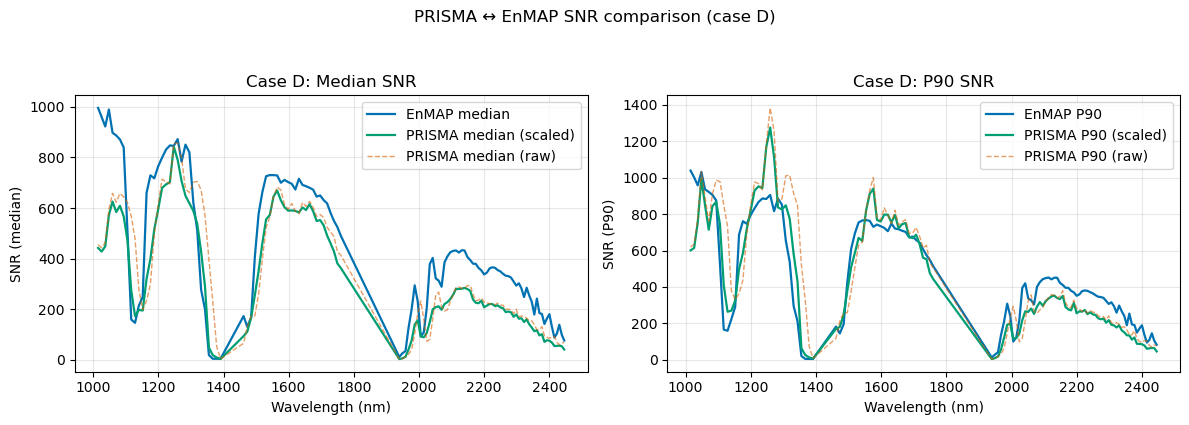

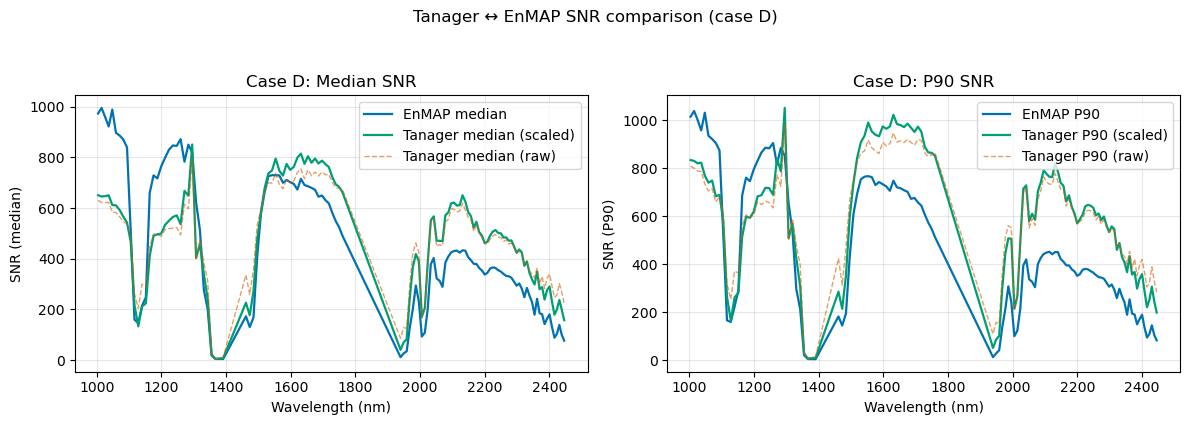

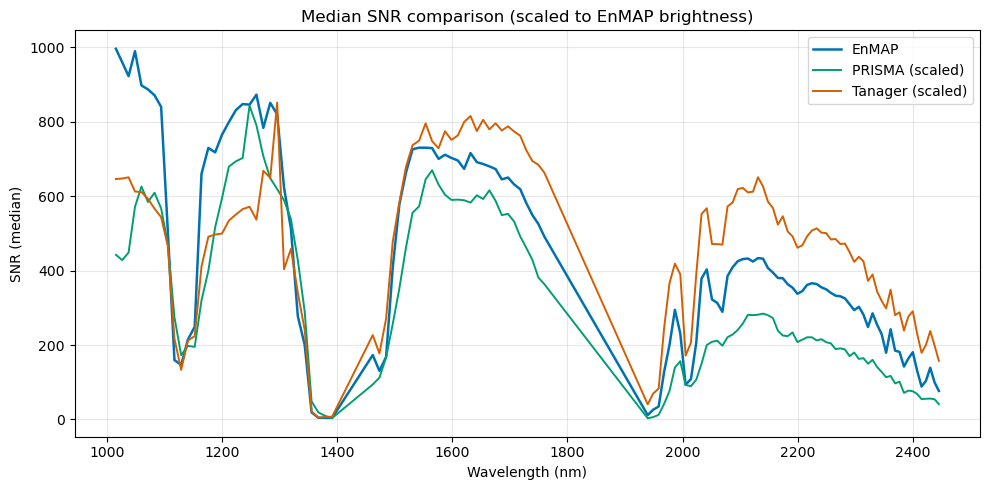

In [28]:

# Load EnMAP reference, then align PRISMA and TANAGER to EnMAP
enmap_cases = {case: load_snr_case("enmap", case, aggregation=SNR_AGGREGATION) for case in DEFAULT_SNR_CASES}
prisma_cases = {case: load_snr_case("prisma", case, aggregation=SNR_AGGREGATION) for case in DEFAULT_SNR_CASES}
tanager_cases = {case: load_snr_case("tanager", case, aggregation=SNR_AGGREGATION) for case in DEFAULT_SNR_CASES}

prisma_vs_enmap = {case: align_and_scale_snr(enmap_cases[case], prisma_cases[case]) for case in DEFAULT_SNR_CASES}
tanager_vs_enmap = {case: align_and_scale_snr(enmap_cases[case], tanager_cases[case]) for case in DEFAULT_SNR_CASES}

print("PRISMA vs EnMAP summary:")
display(summarise_snr_cases(prisma_vs_enmap))
print("Tanager vs EnMAP summary:")
display(summarise_snr_cases(tanager_vs_enmap))

for case, df in prisma_vs_enmap.items():
    plot_snr_case(df, case, ref_label="EnMAP", other_label="PRISMA")
for case, df in tanager_vs_enmap.items():
    plot_snr_case(df, case, ref_label="EnMAP", other_label="Tanager")

# Combined overlay (median) on common wavelength grid
case = DEFAULT_SNR_CASES[0]
df_p = prisma_vs_enmap[case]
df_t = tanager_vs_enmap[case]
wl_common = np.intersect1d(df_p["band_nm"].to_numpy(), df_t["band_nm"].to_numpy())

def _subset(df):
    return df[df["band_nm"].isin(wl_common)].sort_values("band_nm")

dp = _subset(df_p)
dt = _subset(df_t)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dp["band_nm"], dp["snr_median_ref"], label="EnMAP", lw=1.8)
ax.plot(dp["band_nm"], dp["snr_median_other_scaled"], label="PRISMA (scaled)", lw=1.4)
ax.plot(dt["band_nm"], dt["snr_median_other_scaled"], label="Tanager (scaled)", lw=1.4)
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("SNR (median)")
ax.set_title("Median SNR comparison (scaled to EnMAP brightness)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


## Save SNR reference (Tanager)

In [29]:

# Save Tanager SNR reference (Columnwise)
# Adjust input/output/ROI/bands as needed; PRISMA/EnMAP blocks provided below (commented out).
import os, sys, subprocess

cmd = [
    sys.executable,
    "-m",
    "scripts.SNR_tanager_reference",
    "--input",
    str(REPO_ROOT / "test_data" / "tanager" / "20250509_090323_87_4001" / "basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5"),
    "--output",
    str(NOTEBOOK_ROOT / "outputs" / "tanager" / "snr_reference_columnwise.npz"),
    "--bands",
    "1000:2500",
    "--roi",
    "0:607,0:234",
    "--mask-frac",
    "0.12",
    "--k-pca",
    "4",
    "--sigma-mode",
    "diff",
]

env = dict(os.environ)
env.setdefault("PYTHONPATH", str(REPO_ROOT))
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True, cwd=REPO_ROOT, env=env)
print("Saved Tanager SNR reference to", NOTEBOOK_ROOT / "outputs" / "tanager" / "snr_reference_columnwise.npz")

# Optional: generate PRISMA/EnMAP references (uncomment to run)
# subprocess.run([
#     sys.executable, "-m", "scripts.snr_experiment", "--sensor", "prisma", "--input",
#     str(REPO_ROOT / "test_data" / "prisma" / "Northern_State_Sudan_20200401" / "20200401085313_20200401085318" / "PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip"),
#     "--bands", "1000:2500", "--cases", "D", "--outdir", str(NOTEBOOK_ROOT / "outputs"),
# ], cwd=REPO_ROOT, env=env, check=True)
# subprocess.run([
#     sys.executable, "-m", "scripts.snr_experiment", "--sensor", "enmap", "--input",
#     str(REPO_ROOT / "test_data" / "enmap" / "Agadez_Niger_20220712" / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z"),
#     "--bands", "1000:2500", "--cases", "D", "--outdir", str(NOTEBOOK_ROOT / "outputs"),
# ], cwd=REPO_ROOT, env=env, check=True)


Running: /home/esivla/miniconda3/envs/hygasMF/bin/python -m scripts.SNR_tanager_reference --input /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/tanager/20250509_090323_87_4001/basic_radiance_hdf5__20250509_090323_87_4001_basic_radiance_hdf5.h5 --output /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/snr_reference_columnwise.npz --bands 1000:2500 --roi 0:607,0:234 --mask-frac 0.12 --k-pca 4 --sigma-mode diff
Saved Tanager SNR reference to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/snr_reference_columnwise.npz
Saved Tanager SNR reference to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/snr_reference_columnwise.npz



## Columnwise SNR heatmaps (per sensor)
Load columnwise SNR references and visualise SNR across bands × columns. Paths for PRISMA/EnMAP are provided as examples; update them to your references if needed.


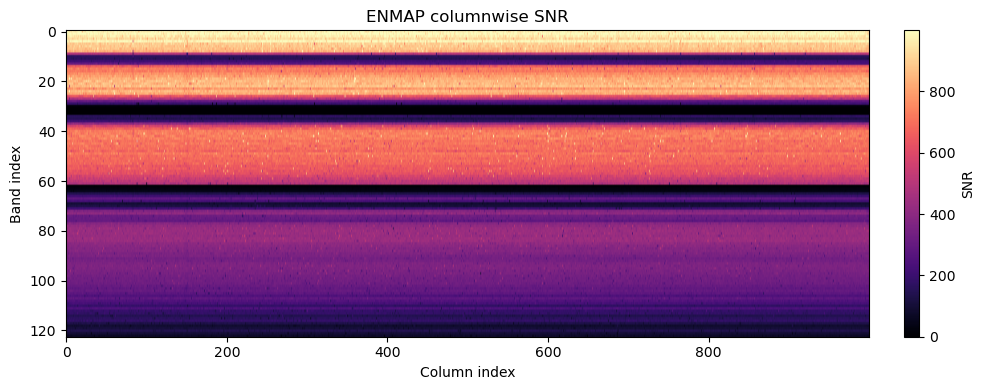

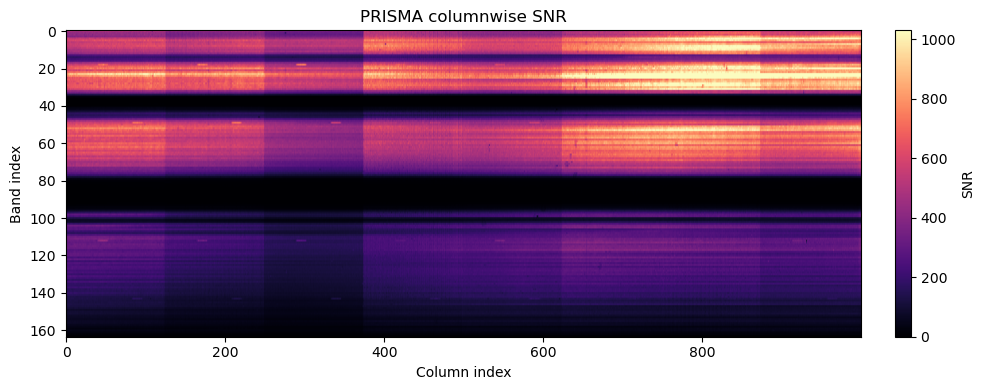

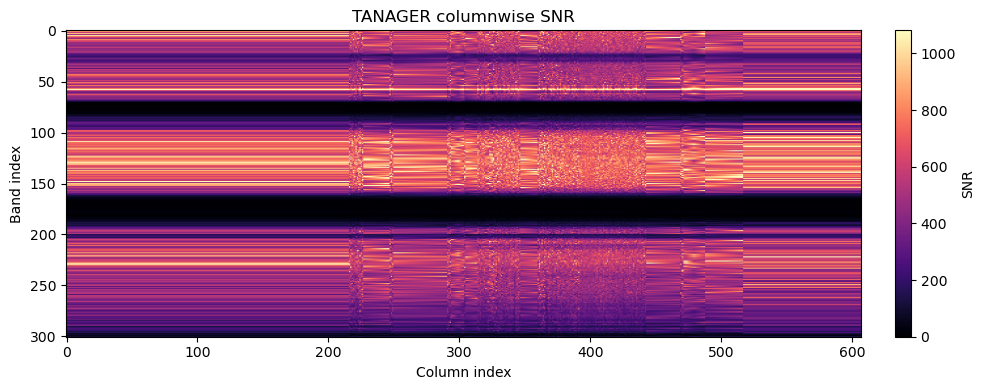

In [30]:

import matplotlib.pyplot as plt
from scripts.core import noise

REF_PATHS = {
    "enmap": NOTEBOOK_ROOT / "outputs" / "enmap" / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z" / "snr_reference_columnwise.npz",
    "prisma": NOTEBOOK_ROOT / "outputs" / "prisma" / "20200401085313" / "snr_reference_columnwise.npz",
    "tanager": NOTEBOOK_ROOT / "outputs" / "tanager" / "snr_reference_columnwise.npz",
}

for sensor, path in REF_PATHS.items():
    if not path.exists():
        print(f"[WARN] Missing reference for {sensor}: {path}")
        continue
    ref = noise.ColumnwiseSNRReference.load(path)
    snr = ref.snr
    wl = ref.band_nm
    fig, ax = plt.subplots(figsize=(10, 4))
    vmax = np.nanpercentile(snr, 99)
    im = ax.imshow(snr, aspect='auto', origin='upper', cmap='magma', vmin=0, vmax=vmax)
    ax.set_title(f"{sensor.upper()} columnwise SNR")
    ax.set_xlabel("Column index")
    ax.set_ylabel("Band index")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("SNR")
    plt.tight_layout()
    plt.show()



## Columnwise SNR summaries (per sensor)
Load each columnwise SNR reference and plot mean radiance and SNR across bands, plus key stats. Update the reference paths if yours differ.


PRISMA reference: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz
  bands: 164 columns: 1000
  wavelength range: 1008.29248046875 → 2496.7607421875
  SNR min/median/max: 0.0 220.0735626220703 1593.92822265625
  SNR < 5: 15748
  NaNs: 0
  Radiance unit scaled to: Radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)


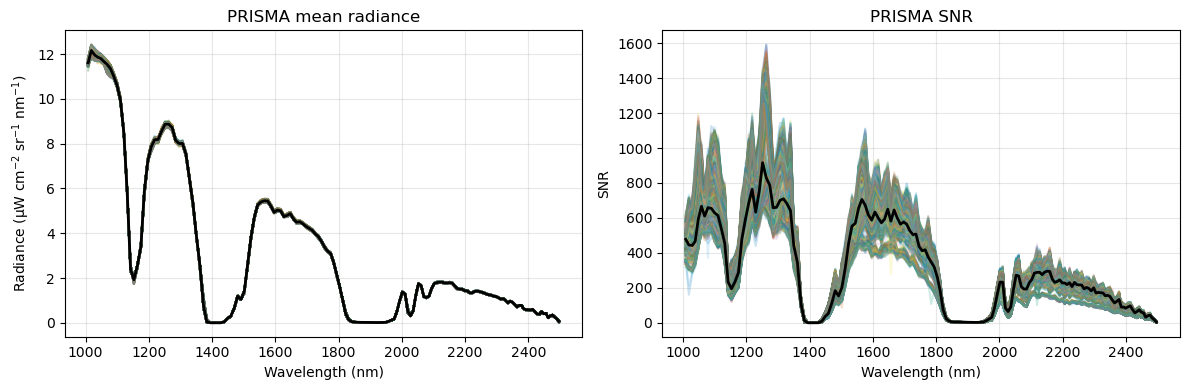

EnMAP reference: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/snr_reference_columnwise.npz
  bands: 123 columns: 1000
  wavelength range: 1004.2100219726562 → 2445.530029296875
  SNR min/median/max: 0.9389997124671936 377.48065185546875 2119.450927734375
  SNR < 5: 2362
  NaNs: 0
  Radiance unit scaled to: Radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)


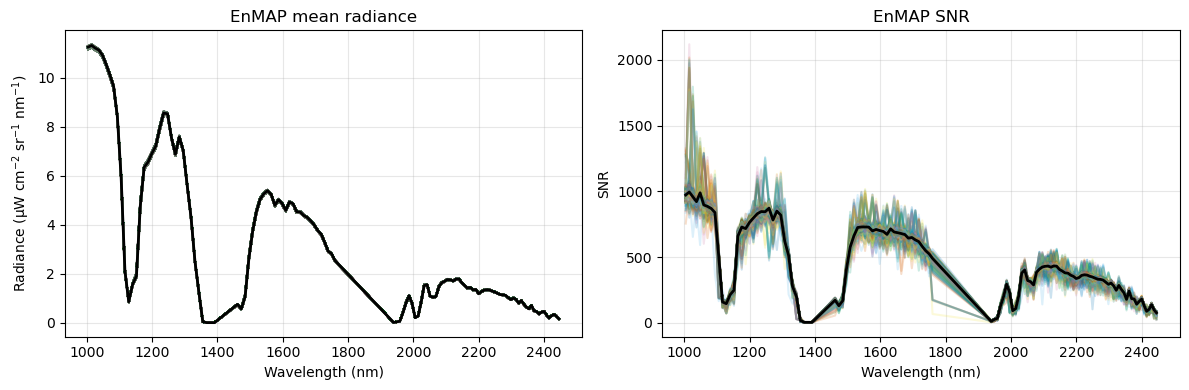

Tanager reference: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/tanager/snr_reference_columnwise.npz
  bands: 301 columns: 607
  wavelength range: 1001.6400146484375 → 2499.0
  SNR min/median/max: -3.6201539039611816 456.77685546875 1766.2998046875
  SNR < 5: 4057
  NaNs: 0
  Radiance unit scaled to: Radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)


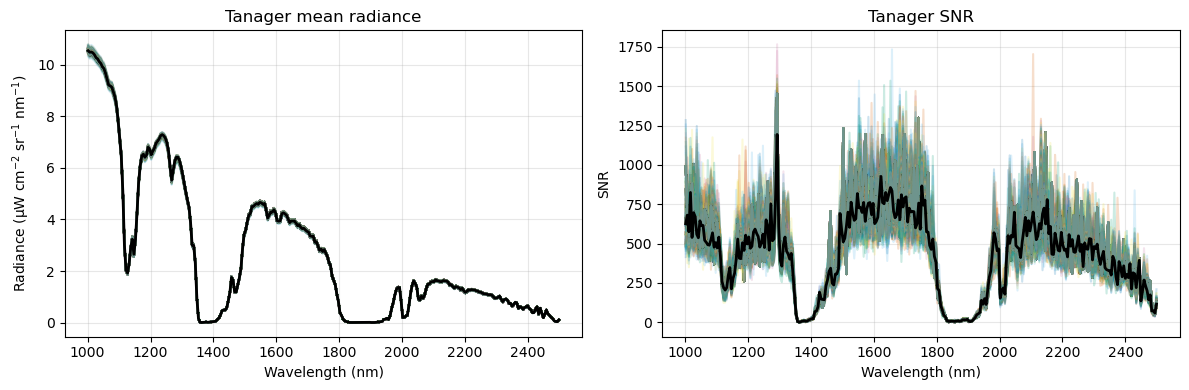

In [31]:

import matplotlib.pyplot as plt
from scripts.core import noise

UNIT_SCALE = {
    'prisma': 1.0,
    'enmap': 1.0,
    'tanager': 0.1,  # W m^-2 sr^-1 µm^-1 -> µW cm^-2 sr^-1 nm^-1
}
RAD_UNIT = "Radiance (µW cm$^{-2}$ sr$^{-1}$ nm$^{-1}$)"

def summarise_reference(path, label, sensor):
    ref = noise.ColumnwiseSNRReference.load(path)
    snr = ref.snr
    mu = ref.mean_radiance * UNIT_SCALE.get(sensor, 1.0)
    wl = ref.band_nm
    print(f"{label} reference: {path}")
    print('  bands:', wl.shape[0], 'columns:', snr.shape[1])
    print('  wavelength range:', float(np.nanmin(wl)), '→', float(np.nanmax(wl)))
    print('  SNR min/median/max:', float(np.nanmin(snr)), float(np.nanmedian(snr)), float(np.nanmax(snr)))
    print('  SNR < 5:', int(np.sum(snr < 5)))
    print('  NaNs:', int(np.isnan(snr).sum()))
    print(f'  Radiance unit scaled to: {RAD_UNIT}')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(wl, mu, alpha=0.25)
    axes[0].plot(wl, np.nanmedian(mu, axis=1), color='k', lw=2, label='median')
    axes[0].set_title(f"{label} mean radiance")
    axes[0].set_xlabel("Wavelength (nm)")
    axes[0].set_ylabel(RAD_UNIT)
    axes[0].grid(alpha=0.3)
    axes[1].plot(wl, snr, alpha=0.2)
    axes[1].plot(wl, np.nanmedian(snr, axis=1), color='k', lw=2, label='median')
    axes[1].set_title(f"{label} SNR")
    axes[1].set_xlabel("Wavelength (nm)")
    axes[1].set_ylabel("SNR")
    axes[1].set_yscale('linear')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

refs = [
    (NOTEBOOK_ROOT / "outputs" / "prisma" / "20200401085313" / "snr_reference_columnwise.npz", "PRISMA", "prisma"),
    (NOTEBOOK_ROOT / "outputs" / "enmap" / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z" / "snr_reference_columnwise.npz", "EnMAP", "enmap"),
    (NOTEBOOK_ROOT / "outputs" / "tanager" / "snr_reference_columnwise.npz", "Tanager", "tanager"),
]

for path, label, sensor in refs:
    if path.exists():
        summarise_reference(path, label, sensor)
    else:
        print(f"[WARN] Missing reference: {label} -> {path}")
